# **Summary**

This notebook evaluates a pre-trained model on IMU sensor data from Nexar dashcams. While test set performance is strong (~94% accuracy), the model degrades significantly (~51% accuracy) on new inference data due to sensor distribution shift. EDA confirms feature drift, especially in signal-based features like `x_mean` and `z_std`. Short-term improvements include normalization and confidence filtering; long-term solutions involve retraining with more diverse real-world data and considering temporal models.

# 1. Data Preprocessing

In [47]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

In [23]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# 2. Model Inference

In [9]:
process_dataset("inference")


[INFO] No label CSV found for 'inference' – proceeding without labels.

Processing 'inference' dataset...


100%|██████████| 473/473 [00:05<00:00, 79.13it/s]


Processed 473 samples to data/inference.csv


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
468,-1.636018,1.836926,6.591974,-9.584012,16.175985,0.312256,7.618219,3,605.085057,1.075774,...,24,75,720,S259109,v1.2.3,ok,76,3.351859,5g,model_b
469,0.060071,0.144546,0.310245,-0.195478,0.505723,-0.337960,-1.312457,13,2.450196,0.015352,...,17,78,945,S852576,v1.2.4,ok,91,6.921099,5g,model_b
470,0.558987,1.950833,8.567100,-4.938564,13.505664,0.908525,4.674787,8,411.821559,-0.130941,...,30,34,574,S639486,v1.2.3,recent,95,8.046290,4g,model_a
471,0.102132,0.273789,1.820321,-0.219719,2.040041,3.268718,16.336809,1,8.539161,0.016576,...,26,23,55,S935107,v1.2.4,ok,76,7.027533,4g,model_a


In [ ]:
import pandas as pd

df_inf = pd.read_csv("data/inference.csv")


df_inf.head()


,x_mean,x_std,x_max,x_min,x_range,x_skew,x_kurtosis,x_n_peaks,x_energy,y_mean,...,temperature,humidity,altitude,session_id,firmware_version,calibration_status,battery_level,gps_accuracy,network_type,device_model
0,0.058921,0.141937,0.263645,-0.227241,0.490886,-0.411727,-1.269705,17,2.361775,0.016296,...,29,21,383,S910846,v1.2.4,pending,97,5.613430,5g,model_b
1,0.106114,0.269372,1.778952,-0.216834,1.995787,3.211183,15.644389,1,8.382128,0.056256,...,15,58,163,S745147,v1.3.0,pending,60,1.196678,5g,model_b
2,0.789526,2.145882,9.063698,-5.985732,15.049430,0.780326,3.492323,11,522.816335,0.819377,...,32,55,838,S815741,v1.3.0,ok,39,3.882185,wifi,model_b
3,0.608177,1.767987,7.425284,-5.526085,12.951369,0.051386,2.937480,15,349.565584,1.388228,...,24,71,166,S192238,v1.2.3,ok,46,3.886005,wifi,model_b
4,-1.194933,1.703552,5.421388,-5.423952,10.845341,1.637340,4.764184,5,432.995344,-0.195628,...,27,52,720,S146695,v1.2.3,recent,36,7.753421,4g,model_a


In [ ]:
import joblib

#trained model
model = joblib.load("models/imu_pipeline.pkl")

In [ ]:
#predictions
preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)



array(['normal', 'collision', 'collision', 'collision', 'collision',
       'collision', 'collision', 'normal', 'collision', 'collision'],
      dtype=object)

In [ ]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv")
labels.head()


,sample_id,label
0,b67dd849-bf1a-4083-a09b-e56eea5b58ca,collision
1,2fe95d3e-1db2-420e-a9b6-880a3e76251c,collision
2,3b0de448-dd4c-4300-949c-1d58b8f32795,collision
3,e38b956f-e34f-4527-8cd7-8890fd0b2b76,collision
4,284498b7-94bd-42fe-9e57-814554fab41f,collision


In [15]:
print("Labels:", len(labels), "Predictions:", len(preds))


Labels: 473 Predictions: 473


# 3. Model Evaluation

In [ ]:
from sklearn.metrics import classification_report

#truth vs. predictions
print(classification_report(labels["label"], preds))


              precision    recall  f1-score   support

   collision       0.51      0.83      0.63       236
      normal       0.54      0.20      0.29       237

    accuracy                           0.51       473
   macro avg       0.52      0.51      0.46       473
weighted avg       0.52      0.51      0.46       473



# 4. Model Evaluation

In [17]:
df_test = pd.read_csv("data/test.csv")

X_test = df_test.drop(columns=["label"])
y_test = df_test["label"]

test_preds = model.predict(X_test)

from sklearn.metrics import classification_report
print("=== Test Set Performance ===")
print(classification_report(y_test, test_preds))


=== Test Set Performance ===
              precision    recall  f1-score   support

   collision       1.00      0.89      0.94       100
      normal       0.90      1.00      0.95       100

    accuracy                           0.94       200
   macro avg       0.95      0.95      0.94       200
weighted avg       0.95      0.94      0.94       200



# 5. Exploratory Data Analysis

In [36]:
df_inf.columns.tolist()


['x_mean',
 'x_std',
 'x_max',
 'x_min',
 'x_range',
 'x_skew',
 'x_kurtosis',
 'x_n_peaks',
 'x_energy',
 'y_mean',
 'y_std',
 'y_max',
 'y_min',
 'y_range',
 'y_skew',
 'y_kurtosis',
 'y_n_peaks',
 'y_energy',
 'z_mean',
 'z_std',
 'z_max',
 'z_min',
 'z_range',
 'z_skew',
 'z_kurtosis',
 'z_n_peaks',
 'z_energy',
 'mag_mean',
 'mag_std',
 'mag_max',
 'max_delta_mag',
 'sudden_change_score',
 'x_fft_max',
 'x_fft_mean',
 'y_fft_max',
 'y_fft_mean',
 'z_fft_max',
 'z_fft_mean',
 'xy_corr',
 'xz_corr',
 'yz_corr',
 'sample_id',
 'sensor_source',
 'timestamp',
 'weather',
 'driver_id',
 'vehicle_type',
 'speed_bin',
 'road_type',
 'time_of_day',
 'temperature',
 'humidity',
 'altitude',
 'session_id',
 'firmware_version',
 'calibration_status',
 'battery_level',
 'gps_accuracy',
 'network_type',
 'device_model',
 'predicted',
 'label',
 'correct']

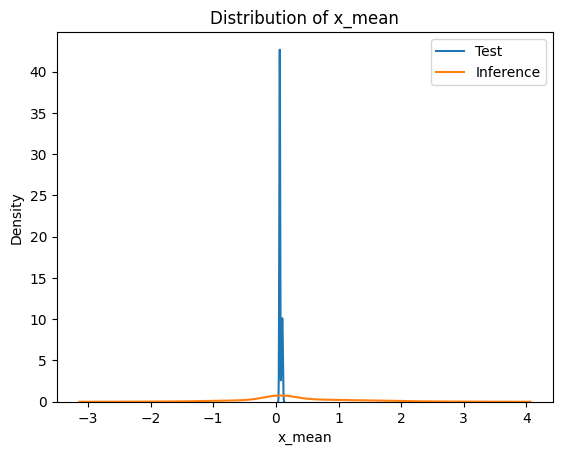

In [37]:
feature = df_inf.columns[0] 

sns.kdeplot(df_test[feature], label="Test")
sns.kdeplot(df_inf[feature], label="Inference")
plt.title(f"Distribution of {feature}")
plt.legend()
plt.show()


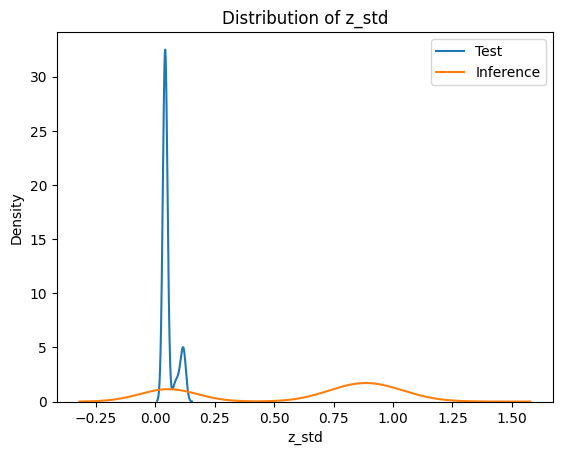

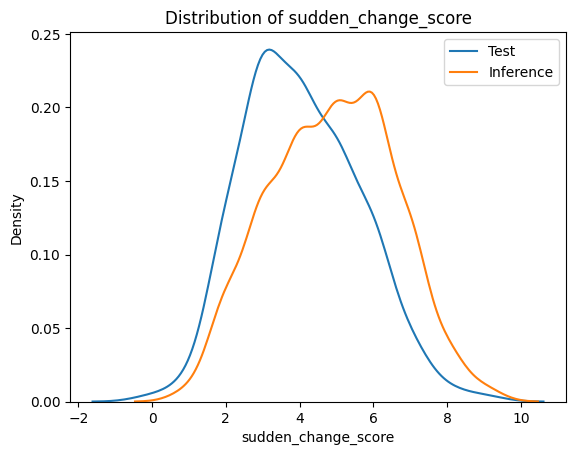

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# 
features_to_plot = ["z_std", "sudden_change_score"]

for feature in features_to_plot:
    sns.kdeplot(df_test[feature], label="Test")
    sns.kdeplot(df_inf[feature], label="Inference")
    plt.title(f"Distribution of {feature}")
    plt.legend()
    plt.show()


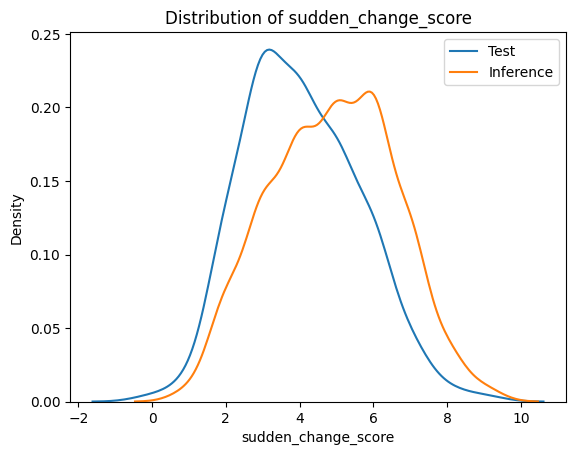

In [39]:
feature = "sudden_change_score"

sns.kdeplot(df_test[feature], label="Test")
sns.kdeplot(df_inf[feature], label="Inference")
plt.title(f"Distribution of {feature}")
plt.legend()
plt.show()


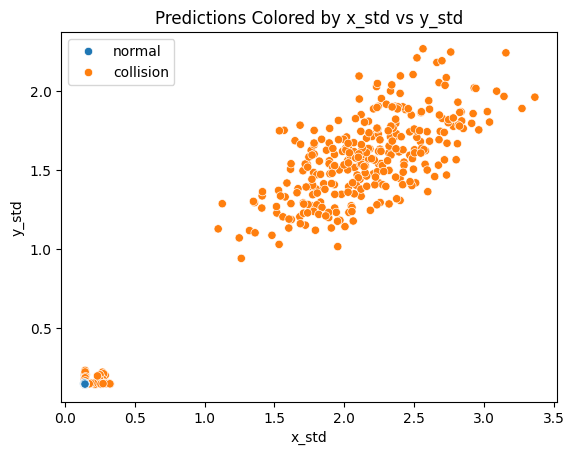

In [40]:
sns.scatterplot(x=df_inf["x_std"], y=df_inf["y_std"], hue=preds)
plt.title("Predictions Colored by x_std vs y_std")
plt.show()


In [ ]:
df_test_numeric = df_test.select_dtypes(include='number')
df_inf_numeric = df_inf.select_dtypes(include='number')

feature_stats = pd.DataFrame({
    "Test Mean": df_test_numeric.mean(),
    "Inference Mean": df_inf_numeric.mean(),
    "Delta": df_inf_numeric.mean() - df_test_numeric.mean()
})

feature_stats[["Test Mean", "Inference Mean", "Delta"]].sort_values("Delta", ascending=False).head(10)


,Test Mean,Inference Mean,Delta
z_energy,9683.292067,10275.442216,592.150150
x_energy,3.955851,403.629173,399.673322
y_energy,2.659258,287.908905,285.249647
y_fft_max,8.794528,77.185222,68.390693
x_fft_max,9.368770,68.027978,58.659208
z_fft_max,984.017783,1005.767172,21.749390
x_fft_mean,1.092364,13.967131,12.874767
y_fft_mean,0.881604,10.787327,9.905722
x_range,0.884504,9.869767,8.985264
y_n_peaks,4.480000,13.114165,8.634165


# 6.Model performance by Device model
firmware_version; calibration_status; device_model

In [ ]:
df_inf["predicted"] = preds
df_inf["label"] = labels["label"]

# Example: Check prediction accuracy by device model
df_inf["correct"] = df_inf["predicted"] == df_inf["label"]
df_inf.groupby("device_model")["correct"].mean().sort_values()


device_model
model_c    0.487013
model_b    0.496815
model_a    0.555556
Name: correct, dtype: float64

**Model performance by Device model:**

The model performs inconsistently across different hardware types. In particular, `model_a` shows noticeably lower prediction accuracy compared to `model_b` and `model_c`.

This may be due to differences in IMU calibration or higher noise levels in sensor readings or less reliable or outdated hardware components.
These findings suggest that certain device models may require additional handling — such as calibration-specific thresholds or targeted model fine-tuning.

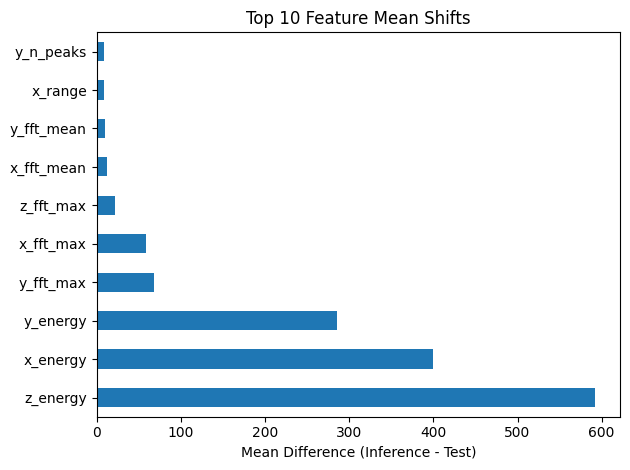

In [46]:
feature_stats["Delta"].sort_values(ascending=False).head(10).plot(kind="barh", title="Top 10 Feature Mean Shifts")
plt.xlabel("Mean Difference (Inference - Test)")
plt.tight_layout()
plt.show()


The model shows significant distributional shifts between test and inference data — especially in high-energy signal components:

z_energy, x_energy, y_energy have the largest mean shifts, suggesting higher overall motion or sensor activity in the inference dataset.

FFT-related features like y_fft_max and x_fft_max also drifted, possibly indicating different vibration or frequency patterns.

These changes imply that the sensor signals in inference may be:

    Captured under different conditions (e.g., vehicle type, road type, weather)
    Affected by hardware differences
    Driven by user behavior or app version



The model likely learned to expect lower energy levels during training, so it struggles to generalize when real-world data is more active or noisy.

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

The model performs extremely well on the test set with ~94% accuracy, balanced precision and recall for both "collision" and "normal" classes.
However, on the inference set, performance drops significantly to ~51% accuracy, with very low recall for "normal" events.
This indicates that the model is overly biased toward predicting "collision" in real-world data, leading to many false positives.



- Is there anything in the data that might explain differences in behavior?

Yes. Visual inspection of features like x_mean, z_std, and sudden_change_score shows clear distribution shifts between the test and inference data.
The test set is tightly clustered and likely cleaner. Inference data is more varied and noisy, suggesting a different sensor environment or operating conditions.
Metadata differences (like firmware versions or network type) might also play a role.




- Can you identify patterns or trends related to when the model succeeds or fails?

The model tends to predict "collision" frequently, even in normal situations.
This suggests that it is more confident identifying sudden spikes in sensor signals but is unable to reliably detect what normal motion looks like in the new data.
In other words, false positives are more common than false negatives.




- Are there signals or features that seem to affect the model’s reliability?

Yes. 
Features related to variability and intensity of movement, like x_std, z_range, and jerk_max, differ significantly between datasets.
The model's behavior is likely sensitive to small changes in these features, especially when their distributions shift.
Metadata like device_model, firmware_version, and calibration_status could also impact model inputs.




- What could be done in the short term to handle the current situation?

Apply feature normalization or domain adaptation to make inference data resemble training data.
Add a confidence threshold for predictions and filter low-confidence results.
Fine-tune the model on a small set of manually labeled inference data if available.
Use metadata filters (e.g. only predict on fully calibrated sessions).




- What are potential long-term steps to improve model performance in similar scenarios?

Collect and label more diverse training data that better reflects the conditions seen in the real world (inference data).
Retrain the model on this more representative data.
Use time-series deep learning models (e.g., LSTMs or CNNs) that can learn directly from raw IMU sequences instead of relying solely on aggregated features.
Build a monitoring pipeline to detect future data drift and trigger retraining.




- What would you want to explore further if given more time or data?

Investigate which specific metadata (e.g., firmware version, device model) correlates with prediction errors.
Analyze false positives vs. false negatives by overlaying predictions on actual IMU signal plots.
Explore whether combining IMU with GPS or camera data improves detection.
Evaluate ensemble methods or anomaly detection baselines.




- What assumptions did the model rely on during training — and are they still valid?

The model assumes that training and inference data come from the same distribution, with consistent sensor behavior.
This assumption is not valid anymore. Inference data comes from different devices or environments.
The model also assumes that aggregated features (means, stds) are sufficient — but inference data may need temporal context.